# Moonpower Optimization Runs

Our system contains two battery systems on each side of the transmission line. This simulation optimizes what battery size and weight we should use based off various parameters (System loss, outages, etc.)

### Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Global Variables

In [3]:
numPeriods=100
periodLengthSec=3*60

### Supply and Load Curves

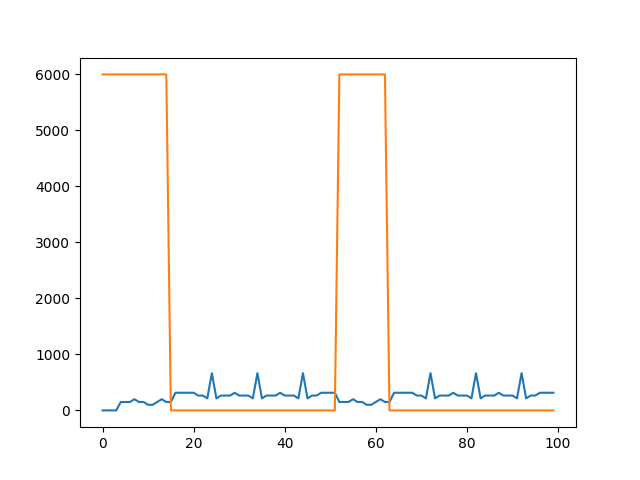

In [4]:
#supply curve
supplyWatts = np.zeros(numPeriods)
supplyWatts[0:15]=6000
supplyWatts[52:63]=6000
supplykWh=supplyWatts * periodLengthSec / 3600

#load curve
loadWatts = np.genfromtxt('wotm_load_curve.csv')

#plot curves
fig = plt.figure()
ax = plt.axes()
ax.plot(loadWatts)
ax.plot(supplyWatts);

### Derived Variables

In [5]:
periodLengthHours=periodLengthSec/3600

loadkWh = loadWatts.sum() /1000 * periodLengthHours


### Specific Run Object

In [6]:
class PowerSystem:

    wireEfficiency=.85      #may eventually parameterize these
    srcBattChargeEfficiency=np.sqrt(.90)   #one-way efficiency
    loadBattChargeEfficiency=np.sqrt(.90)
    srcBattDrainEfficiency=np.sqrt(.90)   #one-way efficiency
    loadBattDrainEfficiency=np.sqrt(.90)

    wireLosskWh=0
    srcBattLosskWh=0
    loadBattLosskWh=0

    loadOutageOccured = False

    timestep=0

    def __init__(self, srcBattCapkWh, loadBattCapkWh, tlineW):
        self.srcBattCapkWh=srcBattCapkWh
        self.loadBattCapkWh=loadBattCapkWh
        self.wireMaxW=tlineW
        
        #intial charges
        self.srcBattSOCkWh=srcBattCapkWh/2 *0 #start with 0 SOC
        self.loadBattSOCkWh=loadBattCapkWh/2 *0

        self.loadBattChargeW =  loadBattCapkWh/3 * 1000 #C/3 charge rate
        self.srcBattChargeW = srcBattCapkWh/3 * 1000

        self.srcBattSOCLogkWh = np.zeros(numPeriods)
        self.loadBattSOCLogkWh = np.zeros(numPeriods)
        self.wireLogW = np.zeros(numPeriods)

    def calcEquivMasskg(self):
        if self.timestep==0:
            print("ERROR: You must call runSim to find losses before running calcEquivMasskg")
        else:
            equivMass = (self.srcBattCapkWh + self.loadBattCapkWh) * 10 #kg/kWh for batt storage
            
            #The rules are poorly written. We have a penalty of "10 g/W". There are 48 hours of actual load operation,
            #so the penalty is really 10 g/48 Wh which equals 0.208333 kg/kWh.
            equivMass += (self.wireLosskWh + self.srcBattLosskWh + self.loadBattLosskWh) * 0.2083333 #kg/kWh

            #This is the 400 V-limited incremental cable mass from Proposal Fig 4
            #Raw Data: Al hot, 100 W = 25 kg 300 W = 50 kg 1 kW = 150 kg
            #Fit is 140 g/W + 9.700 kg
            equivMass += self.wireMaxW * 0.140 #kg/W wire capacity

            return equivMass

    def printRunInfo(self):
        if self.loadOutageOccured:
            print("Load power outage occured: ❌ True")
        else:
            print("Load power outage occured: ✅ False")
        print("Total losses: " + f"{self.srcBattLosskWh+self.loadBattLosskWh+self.wireLosskWh:.3f}" + " kWh")
        print("Wire losses: " + f"{self.wireLosskWh:.3f}" + " kWh")
        print("Batt losses: " + f"{self.srcBattLosskWh+self.loadBattLosskWh:.3f}" + " kWh")

    def runCycle(self,sourceW,loadW):

        srcRemainW=sourceW
        loadRemainW=loadW
        wireRemainW=self.wireMaxW

        #Priority 1: Satisfy load from the direct path
        #Can be limited by: source supply remaining, wire wattage available, load demand
        satSW=min(srcRemainW,wireRemainW,loadRemainW/self.wireEfficiency) #in src-side watts
        
        srcRemainW -= satSW
        wireRemainW -= satSW
        loadRemainW -= satSW * self.wireEfficiency

        self.wireLosskWh += satSW * (1-self.wireEfficiency) * periodLengthHours/1000

        #Priority 2: Satsify load from the source battery
        #Can be limited by: source battery remaining, wire wattage available, load demand
        availBattW=1000 * self.srcBattSOCkWh / periodLengthHours
        satSW=min(availBattW*self.srcBattDrainEfficiency,wireRemainW,loadRemainW/self.wireEfficiency) #in src-side watts

        self.srcBattSOCkWh -= satSW/1000 * periodLengthHours/ self.srcBattDrainEfficiency
        wireRemainW -= satSW
        loadRemainW -= satSW * self.wireEfficiency

        self.wireLosskWh += satSW * (1-self.wireEfficiency) * periodLengthHours/1000
        self.srcBattLosskWh += satSW * (1-self.srcBattDrainEfficiency) * periodLengthHours/1000

        #Priority 3: Satsify load from the load battery
        #Can be limited by: load battery remaining, load demand
        availBattW=1000 * self.loadBattSOCkWh / periodLengthHours
        satSW=min(availBattW*self.loadBattDrainEfficiency,loadRemainW) #in load-side watts

        self.loadBattSOCkWh -= satSW * periodLengthHours/ 1000 / self.loadBattDrainEfficiency
        loadRemainW -= satSW

        self.loadBattLosskWh += satSW * (1-self.loadBattDrainEfficiency) * periodLengthHours/1000

        #End of load power allocation. If load unsatisfied, we have an outage
        if loadRemainW > 0:
            self.loadOutageOccured=True

        #Priority 4: Charge the load battery directly
        #Can be limited by: battery SOC, battery charge rate, wire wattage, source wattage available
        availBattChargeW=min(1000 * (self.loadBattCapkWh-self.loadBattSOCkWh) / periodLengthHours /self.loadBattChargeEfficiency,self.loadBattChargeW)
        satSW=min(availBattChargeW/self.wireEfficiency,wireRemainW,srcRemainW) #in src-side watts

        self.loadBattSOCkWh += satSW/1000 * self.wireEfficiency * self.loadBattChargeEfficiency * periodLengthHours
        wireRemainW -= satSW
        srcRemainW -= satSW

        self.loadBattLosskWh += satSW * self.wireEfficiency * (1-self.loadBattChargeEfficiency) * periodLengthHours/1000
        self.wireLosskWh += satSW * (1-self.wireEfficiency) * periodLengthHours/1000

        #Priority 5: Charge the source battery directly
        #Can be limited by: battery SOC, battery charge rate, source wattage available
        availBattChargeW=min(1000 * (self.srcBattCapkWh-self.srcBattSOCkWh) / periodLengthHours /self.srcBattChargeEfficiency,self.srcBattChargeW)
        satSW=min(availBattChargeW,srcRemainW) #in src-side watts

        self.srcBattSOCkWh += satSW/1000 * self.srcBattChargeEfficiency * periodLengthHours
        srcRemainW -= satSW

        self.srcBattLosskWh += satSW * (1-self.srcBattChargeEfficiency) * periodLengthHours/1000

        #Priority 6: Charge the load battery from the source battery (double conversion)
        #Can be limited by: src batt SOC, load batt SOC, load battery charge rate, wire wattage
        #Mash-up of case 2 and 4
        availBattChargeW=min(1000 * (self.loadBattCapkWh-self.loadBattSOCkWh) / periodLengthHours /self.loadBattChargeEfficiency,self.loadBattChargeW)
        availBattW=1000 * self.srcBattSOCkWh / periodLengthHours
        satSW=min(availBattChargeW/self.wireEfficiency,availBattW*self.srcBattDrainEfficiency,wireRemainW) #in src-side watts

        self.srcBattSOCkWh -= satSW/1000 * periodLengthHours/ self.srcBattDrainEfficiency
        wireRemainW -= satSW
        self.loadBattSOCkWh += satSW/1000 * self.wireEfficiency * self.loadBattChargeEfficiency * periodLengthHours

        self.wireLosskWh += satSW * (1-self.wireEfficiency) * periodLengthHours/1000
        self.srcBattLosskWh += satSW * (1-self.srcBattDrainEfficiency) * periodLengthHours/1000
        self.loadBattLosskWh += satSW * self.wireEfficiency * (1-self.loadBattChargeEfficiency) * periodLengthHours/1000

        #log all the data

        self.srcBattSOCLogkWh[self.timestep] = self.srcBattSOCkWh
        self.loadBattSOCLogkWh[self.timestep] = self.loadBattSOCkWh
        self.wireLogW[self.timestep] = self.wireMaxW - wireRemainW

        #housekeeping
        self.timestep += 1

    def runSim(self,supplyArrayW,loadArrayW):
        for i in range(supplyArrayW.size):
            self.runCycle(supplyArrayW[i],loadArrayW[i])


### Run One Sim

Load power outage occured: ✅ False
Total losses: 0.802 kWh
Wire losses: 0.412 kWh
Batt losses: 0.390 kWh


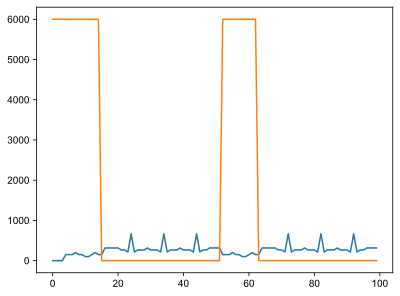

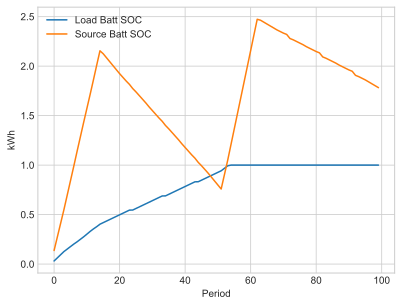

In [7]:
psys1=PowerSystem(10,1,800)
psys1.runSim(supplyWatts,loadWatts)

psys1.printRunInfo()

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.plot(range(numPeriods),psys1.loadBattSOCLogkWh, label='Load Batt SOC')
ax.plot(range(numPeriods),psys1.srcBattSOCLogkWh, label='Source Batt SOC')
plt.xlabel("Period")
plt.ylabel("kWh")
plt.legend();


### Interactive plotting

In [8]:
from sys import float_repr_style
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

def plot_func(sourcecap,loadcap,wirewatts):
    psys1=PowerSystem(sourcecap,loadcap,wirewatts)
    psys1.runSim(supplyWatts,loadWatts)

    psys1.printRunInfo()
    print("Equiv Mass (kg): " +str(psys1.calcEquivMasskg()))

    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(range(numPeriods),psys1.loadBattSOCLogkWh, label='Load Batt SOC')
    ax.plot(range(numPeriods),psys1.srcBattSOCLogkWh, label='Source Batt SOC')
    plt.xlabel("Period")
    plt.ylabel("kWh")
    plt.ylim(-1,max(psys1.loadBattCapkWh,psys1.srcBattCapkWh)*1.1)
    plt.legend()
    plt.show()

    fig2 = plt.figure()
    ax2 = plt.axes()
    ax2.plot(range(numPeriods),psys1.wireLogW, label='Wire wattage')
    plt.xlabel("Period")
    plt.ylabel("W")
    plt.ylim(-5,psys1.wireMaxW*1.1)
    plt.legend()
    plt.show()

interact(plot_func,
        sourcecap = widgets.FloatSlider(value=10, min=0, max=25, step=.25),
        loadcap = widgets.FloatSlider(value=10, min=0, max=25, step=.25),
        wirewatts = widgets.FloatSlider(value=100, min=10, max=1000, step=10)
        );

interactive(children=(FloatSlider(value=10.0, description='sourcecap', max=25.0, step=0.25), FloatSlider(value…

### Sweeps

#### Run Sweep

In [9]:
sourceBattRangekWh=np.arange(0,10 + 0.5,0.5)
loadBattRangekWh=np.arange(0,10 + 0.5,0.5)
wireRangeWatts=np.arange(50,1000 + 50,50)

numsims = sourceBattRangekWh.size * loadBattRangekWh.size * wireRangeWatts.size

simArrays = []

for s in sourceBattRangekWh:
    print("Running source batt=" + str(s))
    for l in loadBattRangekWh:
        for w in wireRangeWatts:
            psys1 = PowerSystem(s,l,w)
            psys1.runSim(supplyWatts,loadWatts)
            
            simArrays.append(psys1)



Running source batt=0.0
Running source batt=0.5
Running source batt=1.0
Running source batt=1.5
Running source batt=2.0
Running source batt=2.5
Running source batt=3.0
Running source batt=3.5
Running source batt=4.0
Running source batt=4.5
Running source batt=5.0
Running source batt=5.5
Running source batt=6.0
Running source batt=6.5
Running source batt=7.0
Running source batt=7.5
Running source batt=8.0
Running source batt=8.5
Running source batt=9.0
Running source batt=9.5
Running source batt=10.0


#### Analyze Sweep

Find Global Minimum Equivalent Mass

In [10]:
plotX=[]
plotY=[]
plotZ=[]
plotR=[]

for i in range(len(simArrays)):
    psys1=simArrays[i]

    if psys1.loadOutageOccured == False:
        plotX.append(psys1.srcBattCapkWh)
        plotY.append(psys1.loadBattCapkWh)
        plotZ.append(psys1.wireMaxW)
        plotR.append(psys1.calcEquivMasskg())

minIdx=np.argmin(plotR)

print("Min Mass (kg): " + str(plotR[minIdx]))
print("Min Src Batt (kWh): " + str(plotX[minIdx]))
print("Min Load Batt (kWh): " + str(plotY[minIdx]))
print("Min Wire Cap (W): " + str(plotZ[minIdx]))

Min Mass (kg): 84.08223296290328
Min Src Batt (kWh): 3.0
Min Load Batt (kWh): 0.5
Min Wire Cap (W): 350


#### Plot Sweep 3D

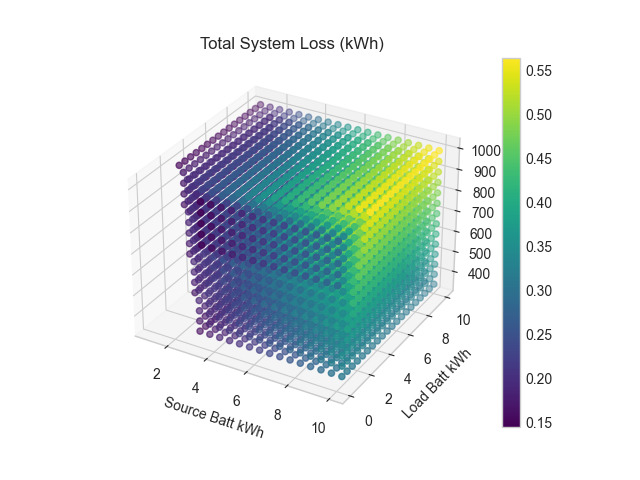

In [15]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')

plotX=[]
plotY=[]
plotZ=[]
plotR=[]

for i in range(len(simArrays)):
    psys1=simArrays[i]

    if psys1.loadOutageOccured == False:
        plotX.append(psys1.srcBattCapkWh)
        plotY.append(psys1.loadBattCapkWh)
        plotZ.append(psys1.wireMaxW)
        plotR.append(psys1.srcBattLosskWh+psys1.loadBattLosskWh)

p=ax.scatter(plotX,plotY,plotZ,c=plotR,cmap='viridis')

fig.colorbar(p)

ax.set_xlabel("Source Batt kWh")
ax.set_ylabel("Load Batt kWh")
ax.set_zlabel("Wire Capacity W")

ax.set_title("Total System Loss (kWh)")

plt.show()

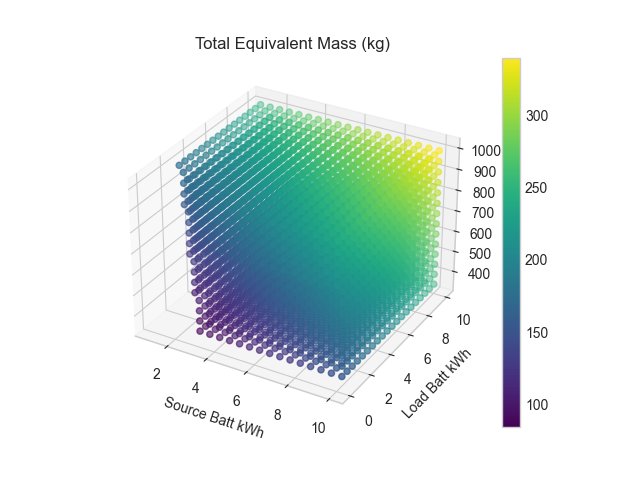

In [16]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')

plotX=[]
plotY=[]
plotZ=[]
plotR=[]

for i in range(len(simArrays)):
    psys1=simArrays[i]

    if psys1.loadOutageOccured == False:
        plotX.append(psys1.srcBattCapkWh)
        plotY.append(psys1.loadBattCapkWh)
        plotZ.append(psys1.wireMaxW)
        plotR.append(psys1.calcEquivMasskg())

p=ax.scatter(plotX,plotY,plotZ,c=plotR,cmap='viridis')
fig.colorbar(p)

ax.set_xlabel("Source Batt kWh")
ax.set_ylabel("Load Batt kWh")
ax.set_zlabel("Wire Capacity W")

ax.set_title("Total Equivalent Mass (kg)")

plt.show()

#### Plot Surface 2D

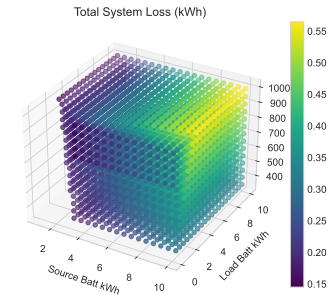

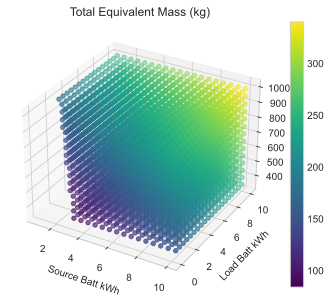

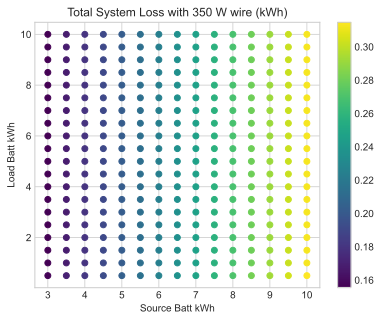

In [13]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

fig = plt.figure()
ax = plt.axes()

plotX=[]
plotY=[]
plotR=[]

for i in range(len(simArrays)):
    psys1=simArrays[i]

    if psys1.loadOutageOccured == False and psys1.wireMaxW==350:
        plotX.append(psys1.srcBattCapkWh)
        plotY.append(psys1.loadBattCapkWh)
        plotR.append(psys1.srcBattLosskWh+psys1.loadBattLosskWh)

p=ax.scatter(plotX,plotY,c=plotR,cmap='viridis')

fig.colorbar(p)

ax.set_xlabel("Source Batt kWh")
ax.set_ylabel("Load Batt kWh")

ax.set_title("Total System Loss with 350 W wire (kWh)")

plt.show()

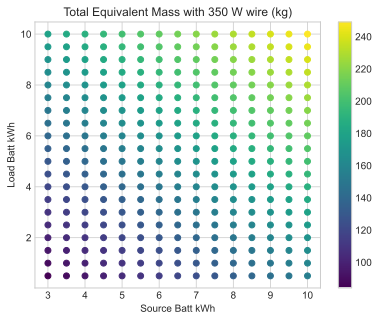

No such comm: df150ed12d0c46968c611a17843951be


In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

fig = plt.figure()
ax = plt.axes()

plotX=[]
plotY=[]
plotR=[]

for i in range(len(simArrays)):
    psys1=simArrays[i]

    if psys1.loadOutageOccured == False and psys1.wireMaxW==350:
        plotX.append(psys1.srcBattCapkWh)
        plotY.append(psys1.loadBattCapkWh)
        plotR.append(psys1.calcEquivMasskg())

p=ax.scatter(plotX,plotY,c=plotR,cmap='viridis')

fig.colorbar(p)

ax.set_xlabel("Source Batt kWh")
ax.set_ylabel("Load Batt kWh")

ax.set_title("Total Equivalent Mass with 350 W wire (kg)")

plt.show()

##### Contour Mass Plot

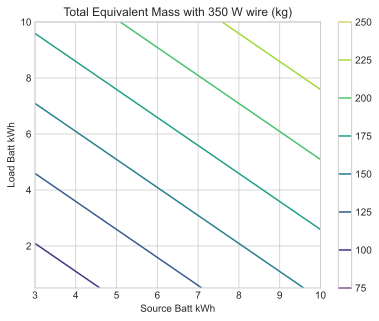

In [ ]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

fig = plt.figure()
ax = plt.axes()

plotX=[]
plotY=[]
plotR=[]

for i in range(len(simArrays)):
    psys1=simArrays[i]

    if psys1.loadOutageOccured == False and psys1.wireMaxW==350:
        plotX.append(psys1.srcBattCapkWh)
        plotY.append(psys1.loadBattCapkWh)
        plotR.append(psys1.calcEquivMasskg())

##Contour
p=ax.tricontour(plotX,plotY,plotR, cmap='viridis')

fig.colorbar(p)

ax.set_xlabel("Source Batt kWh")
ax.set_ylabel("Load Batt kWh")

ax.set_title("Total Equivalent Mass with 350 W wire (kg)")

plt.show()